<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style = "border:2px solid black" ></hr>


**What?** Exponentially weighted moving average - EWMA



# Imports
<hr style = "border:2px solid black" ></hr>

In [1]:
import random
import numpy as np
import numba
import pandas as pd

# Exponentially weighted moving average - EWMA
<hr style = "border:2px solid black" ></hr>


- While pandas allows for sophisticated vectorized operations on DataFrame objects, certain recursive algorithms are hard or impossible to vectorize, leaving the financial analyst with slowly executed Python loops on DataFrame objects.
- Although simple in nature and straightforward to implement, such an algorithm might lead to rather slow code.



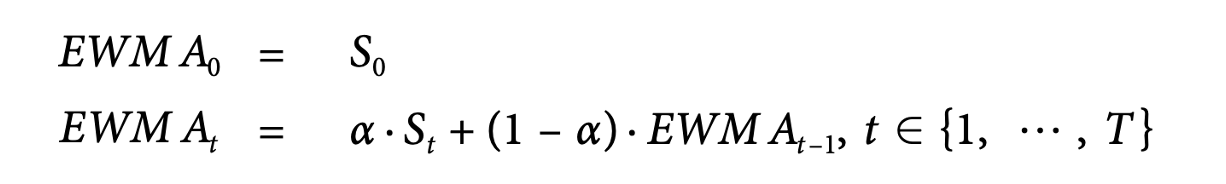

# Import data
<hr style = "border:2px solid black" ></hr>

In [2]:
sym = 'SPY'

In [3]:
data = pd.DataFrame(pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                               index_col=0, parse_dates=True)[sym]).dropna()

In [4]:
alpha = 0.25

In [5]:
data['EWMA'] = data[sym]  

In [6]:
%%time
for t in zip(data.index, data.index[1:]):
    data.loc[t[1], 'EWMA'] = (alpha * data.loc[t[1], sym] +
                              (1 - alpha) * data.loc[t[0], 'EWMA'])  

CPU times: user 391 ms, sys: 5.13 ms, total: 396 ms
Wall time: 398 ms


In [7]:
data.head()

,SPY,EWMA
Date,,
2010-01-04,113.33,113.330000
2010-01-05,113.63,113.405000
2010-01-06,113.71,113.481250
2010-01-07,114.19,113.658438
2010-01-08,114.57,113.886328


In [8]:
data.shape

(2138, 2)

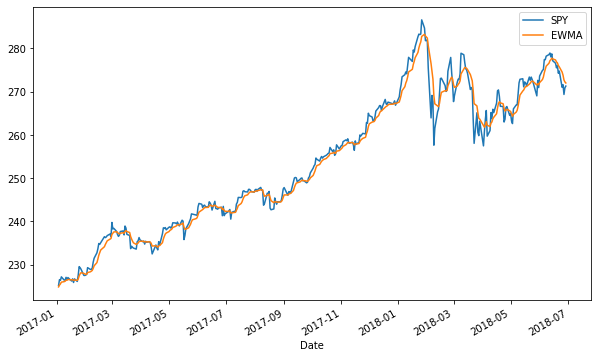

In [9]:
data[data.index > '2017-1-1'].plot(figsize=(10, 6));

### Pure Python

In [10]:
def ewma_py(x, alpha):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1-alpha) * y[i-1]
    return y

In [11]:
%time data['EWMA_PY'] = ewma_py(data[sym], alpha)  

CPU times: user 6.75 ms, sys: 209 µs, total: 6.96 ms
Wall time: 6.9 ms


In [12]:
%time data['EWMA_PY'] = ewma_py(data[sym].values, alpha)  

CPU times: user 1.51 ms, sys: 40 µs, total: 1.55 ms
Wall time: 1.55 ms


### Numba

In [13]:
ewma_nb = numba.jit(ewma_py)

In [14]:
%time data['EWMA_NB'] = ewma_nb(data[sym].values, alpha)  

CPU times: user 970 ms, sys: 127 ms, total: 1.1 s
Wall time: 585 ms


In [15]:
%timeit data['EWMA_NB'] = ewma_nb(data[sym].values, alpha)  

88.6 µs ± 1.87 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Cython

In [24]:
%load_ext Cython

In [25]:
%%cython
import numpy as np
cimport cython
@cython.boundscheck(False)
@cython.wraparound(False)
def ewma_cy(double[:] x, float alpha):
    cdef int i
    cdef double[:] y = np.empty_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1 - alpha) * y[i - 1]
    return y

In [26]:
%time data['EWMA_CY'] = ewma_cy(data[sym].values, alpha)

CPU times: user 984 µs, sys: 383 µs, total: 1.37 ms
Wall time: 1.25 ms


In [27]:
%timeit data['EWMA_CY'] = ewma_cy(data[sym].values, alpha)

115 µs ± 520 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [28]:
data.head()

,SPY,EWMA,EWMA_PY,EWMA_NB,EWMA_CY
Date,,,,,
2010-01-04,113.33,113.330000,113.330000,113.330000,"[113.33, 113.405, 113.48125, 113.6584375, 113...."
2010-01-05,113.63,113.405000,113.405000,113.405000,"[113.33, 113.405, 113.48125, 113.6584375, 113...."
2010-01-06,113.71,113.481250,113.481250,113.481250,"[113.33, 113.405, 113.48125, 113.6584375, 113...."
2010-01-07,114.19,113.658438,113.658438,113.658438,"[113.33, 113.405, 113.48125, 113.6584375, 113...."
2010-01-08,114.57,113.886328,113.886328,113.886328,"[113.33, 113.405, 113.48125, 113.6584375, 113...."


In [29]:
data.tail()

,SPY,EWMA,EWMA_PY,EWMA_NB,EWMA_CY
Date,,,,,
2018-06-25,271.00,274.535176,274.535176,274.535176,"[113.33, 113.405, 113.48125, 113.6584375, 113...."
2018-06-26,271.60,273.801382,273.801382,273.801382,"[113.33, 113.405, 113.48125, 113.6584375, 113...."
2018-06-27,269.35,272.688537,272.688537,272.688537,"[113.33, 113.405, 113.48125, 113.6584375, 113...."
2018-06-28,270.89,272.238903,272.238903,272.238903,"[113.33, 113.405, 113.48125, 113.6584375, 113...."
2018-06-29,271.28,271.999177,271.999177,271.999177,"[113.33, 113.405, 113.48125, 113.6584375, 113...."


# References
<hr style = "border:2px solid black" ></hr>


- https://github.com/yhilpisch/py4fi2nd/blob/master/code/ch10/10_performance_python.ipynb
- https://llvm.org/
- Hilpisch, Yves. Python for finance: mastering data-driven finance. O'Reilly Media, 2018.

